In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
# from particle import Particle

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

In [2]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [6]:
tMC = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out_0.root')['outA']['Tevts']
print tMC.keys(), '\n\n'
branches = tMC.keys()
for b in np.sort(branches):
    print b

['LumiBlock', 'MC_B_P', 'MC_B_eta', 'MC_B_phi', 'MC_B_pt', 'MC_D0_P', 'MC_D0_eta', 'MC_D0_phi', 'MC_D0_pt', 'MC_Dst_P', 'MC_Dst_eta', 'MC_Dst_phi', 'MC_Dst_pt', 'MC_Est_mu', 'MC_M2_miss', 'MC_mu_P', 'MC_mu_eta', 'MC_mu_phi', 'MC_mu_pt', 'MC_pis_P', 'MC_pis_eta', 'MC_pis_phi', 'MC_pis_pt', 'MC_q2', 'Run', 'eventNumber', 'n_B', 'n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'B_E', 'B_P', 'B_eta', 'B_phi', 'B_pt', 'B_pz', 'D0_E', 'D0_P', 'D0_eta', 'D0_phi', 'D0_pt', 'D0_pz', 'Dst_E', 'Dst_P', 'Dst_eta', 'Dst_phi', 'Dst_pt', 'Dst_pz', 'Est_mu', 'K_E', 'K_P', 'K_eta', 'K_phi', 'K_pt', 'K_pz', 'M2_miss', 'chi2_D0pis', 'chi2_MuDst', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_MuDst_vtxBest', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_MuDst', 'mass_kpi', 'mu_E', 'mu_P', 'mu_eta', 'mu_phi', 'mu_pt', 'mu_pz', 'pi_E', 'pi_P', 'pi_eta', 'pi_phi', 'pi_pt', 'pi_pz', 'pis_E', 'pis_P', 'pis_eta'

In [7]:
fn = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0'
fn += '/B02DstMu_candidates/out*.root'
dMC = extarct_multiple(fn, branches=branches)
print 'Number of candidates:', dMC['mass_kpi'].shape[0]

Number of candidates: 15963


In [8]:
fn = '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0'
fn += '/B02DstMu_candidates/out*.root'
dMC_tau = extarct_multiple(fn, branches=branches)
print 'Number of candidates:', dMC_tau['mass_kpi'].shape[0]

Number of candidates: 7222


In [9]:
# fn = '../data/cmsRD/Run2018D/B02DstMu_19*_BPH*.root'
# dRD = extarct_multiple(fn, branches, flag='data')
# print 'Number of candidates:', dRD['mass_kpi'].shape[0]

# Cuts declaration

In [10]:
cut = {}
cut['cos_MuDst_vtxBest'] = ['>', 0.98]
# cut['chi2_D0pis'] = ['<', 3.84]
# cut['d_vtxkpi_vtxMu'] = ['>', 0.03]
# cut['sigdca_kpi_vtxMu'] = ['>', 2.]

In [11]:
np.max(dMC['chi2_D0pis'])

6.634117

In [12]:
sps.chi2.cdf(3.84, 1)

0.9499564787512949

In [13]:
def createSel(d, cut):
    sel = np.ones_like(d[cut.keys[0]], dtype=bool)
    for k, v in cut.iteritems():
        sel = np.logical_and(sel, ops[v[0]](d[k], v[1]) )
    return sel

## MC only

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


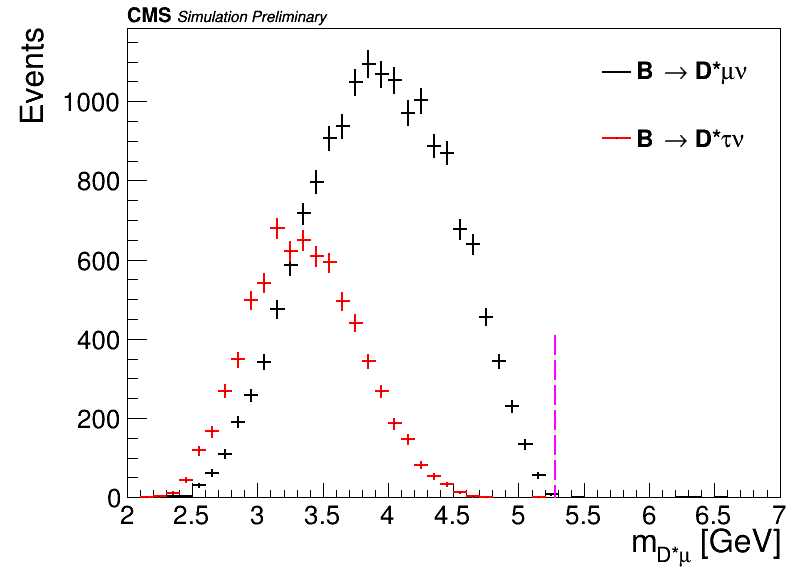

In [14]:
h = create_TH1D(dMC['mass_MuDst'], axis_title=['m_{D*#mu} [GeV]', 'Events'], binning=[50,2,7])
h.Sumw2()
h_tau = create_TH1D(dMC_tau['mass_MuDst'], binning=h.binning)
h_tau.Sumw2()
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h, h_tau], 'same')
cl.DrawLine(m_B0, 0, m_B0, 410)

leg = rt.TLegend(0.75, 0.7,0.95, 0.93)
leg.AddEntry(h, 'B #rightarrow D*#mu#nu')
leg.AddEntry(h_tau, 'B #rightarrow D*#tau#nu')
leg.SetBorderSize(0)
leg.Draw()

In [15]:
sel = []
for nb in dMC['n_B']:
    nb = int(nb)
    if nb == 1:
        sel = sel + [True]
    else:
        sel = sel + nb*[False]

sel = np.array(sel)
sel.shape

(15963,)

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


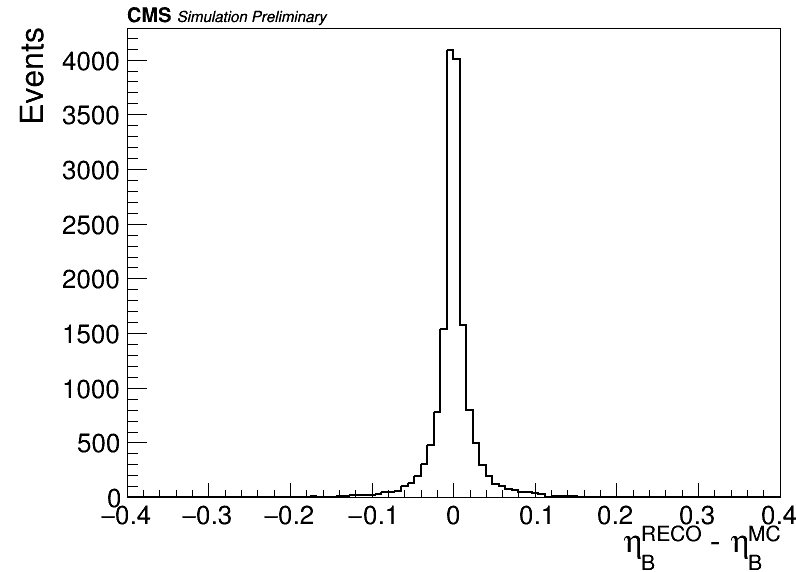

In [16]:
h = create_TH1D(dMC['B_eta'][sel]-dMC['MC_B_eta'][dMC['n_B']==1], axis_title=['#eta_{B}^{RECO} - #eta_{B}^{MC}', 'Events'], binning=[100,-0.4,0.4], opt='underflow')
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


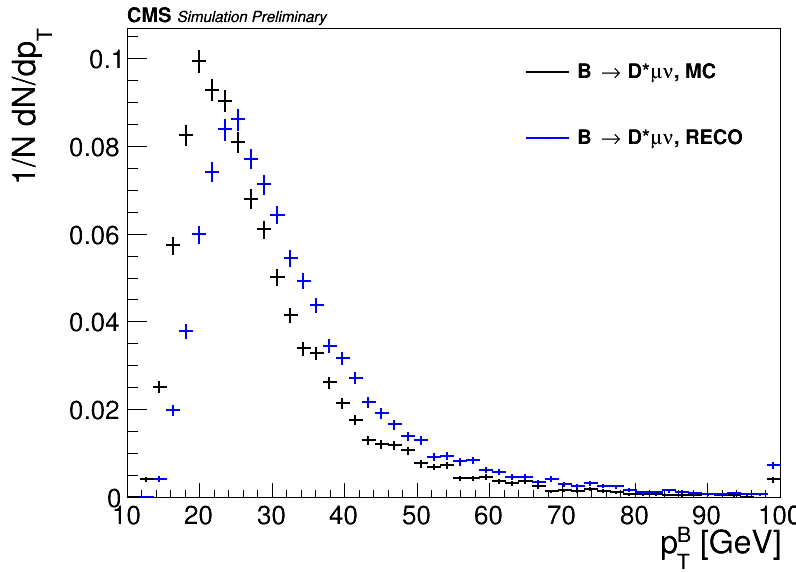

In [17]:
h_muMC = create_TH1D(dMC['MC_B_pt'], name='hmmc', axis_title=['p_{T}^{B} [GeV]', '1/N dN/dp_{T}'], binning=[50,10,100], opt='overflow')
h_muMC.Scale(1./h_muMC.Integral())

h_muRECO = create_TH1D(dMC['B_pt'], name='hmreco', binning=h_muMC.binning, opt='overflow')
h_muRECO.Scale(1./h_muRECO.Integral())
h_muRECO.SetLineColor(4)

# h_tau = create_TH1D(dMC_tau['MC_B_pt'], name='htmc', binning=h_muMC.binning)
# h_tau.SetLineColor(2)
# h_tau.Scale(1./h_tau.Integral())

# h_ta = create_TH1D(dMC_tau['B_pt'], name='htreco', binning=h_muMC.binning)
# h_ta.Scale(1./h_ta.Integral())
# h_ta.SetLineColor(6)

CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h_muMC, h_muRECO], 'same')
# h_tau.Draw("SAME")
# h_ta.Draw("SAME")

leg = rt.TLegend(0.65, 0.7,0.95, 0.93)
leg.AddEntry(h_muMC, 'B #rightarrow D*#mu#nu, MC')
leg.AddEntry(h_muRECO, 'B #rightarrow D*#mu#nu, RECO')
# leg.AddEntry(h_tau, 'B #rightarrow D*#tau#nu, MC')
# leg.AddEntry(h_ta, 'B #rightarrow D*#tau#nu, RECO')
leg.SetBorderSize(0)
leg.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


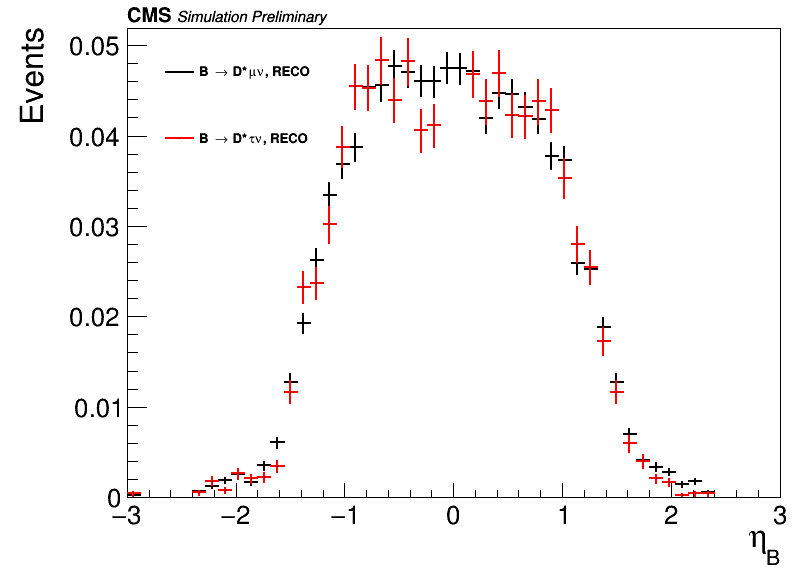

In [18]:
h = create_TH1D(dMC['B_eta'], axis_title=['#eta_{B}', 'Events'], binning=[50, -3, 3], opt='underflow')
h.Scale(1./h.Integral())
h_tau = create_TH1D(dMC_tau['B_eta'], binning=h.binning, opt='underflow')
h_tau.Scale(1./h_tau.Integral())
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h, h_tau], 'same')

leg = rt.TLegend(0.2, 0.7,0.4, 0.93)
# leg.AddEntry(h_muMC, 'B #rightarrow D*#mu#nu, MC')
leg.AddEntry(h, 'B #rightarrow D*#mu#nu, RECO')
# leg.AddEntry(h_tau, 'B #rightarrow D*#tau#nu, MC')
leg.AddEntry(h_tau, 'B #rightarrow D*#tau#nu, RECO')
leg.SetBorderSize(0)
leg.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


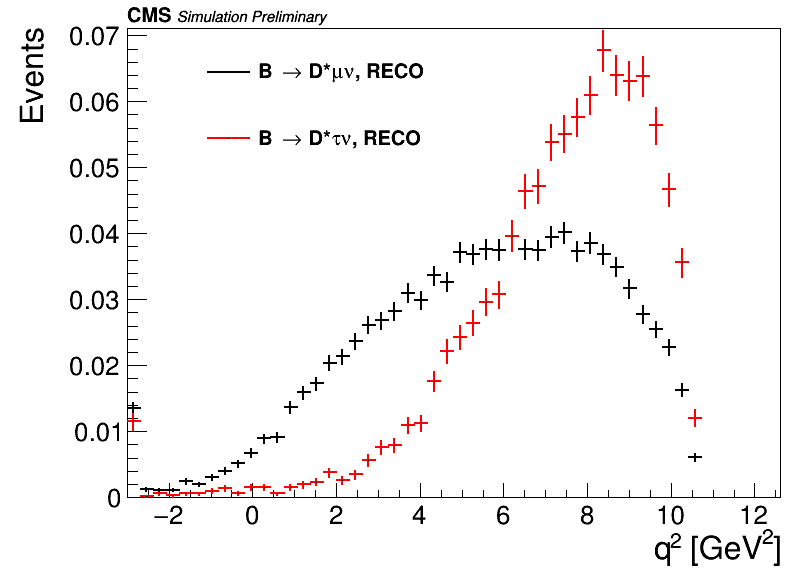

In [19]:
h = create_TH1D(dMC['q2'], axis_title=['q^{2} [GeV^{2}]', 'Events'], binning=[50, -3, 12.6], opt='underflow')
h.Scale(1./h.Integral())
h_tau = create_TH1D(dMC_tau['q2'], binning=h.binning, opt='underflow')
h_tau.Scale(1./h_tau.Integral())
h_tau.SetLineColor(2)
SetMaxToMaxHist([h, h_tau])
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h, h_tau], 'same')

leg = rt.TLegend(0.25, 0.7,0.55, 0.93)
# leg.AddEntry(h_muMC, 'B #rightarrow D*#mu#nu, MC')
leg.AddEntry(h, 'B #rightarrow D*#mu#nu, RECO')
# leg.AddEntry(h_tau, 'B #rightarrow D*#tau#nu, MC')
leg.AddEntry(h_tau, 'B #rightarrow D*#tau#nu, RECO')
leg.SetBorderSize(0)
leg.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


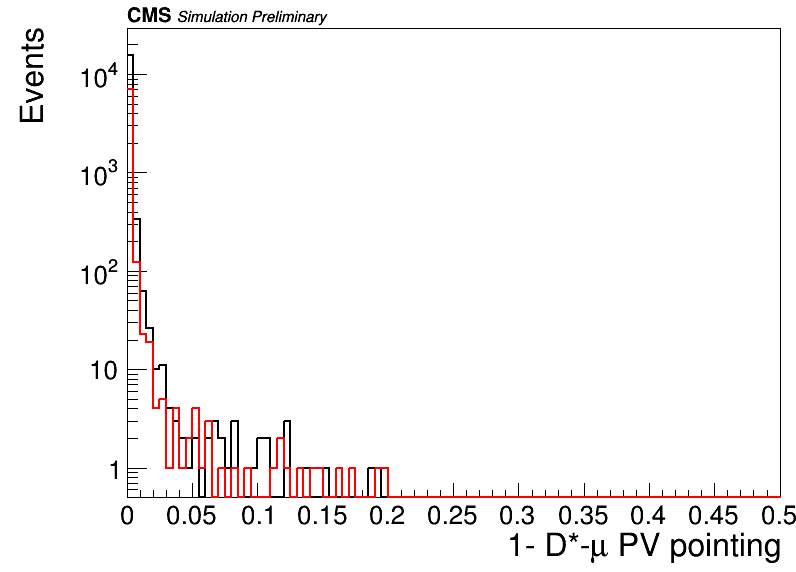

In [20]:
h = create_TH1D(1-dMC['cos_MuDst_vtxBest'], axis_title=['1- D*-#mu PV pointing', 'Events'], binning=[100,0.,0.5])
h_tau = create_TH1D(1-dMC_tau['cos_MuDst_vtxBest'], binning=h.binning)
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h, h_tau], 'same')
c.SetLogy()

In [21]:
binning_q2 = np.linspace(-2, 10.7, 5, True)
N_q2bins = binning_q2.shape[0]-1
print binning_q2

xAx_title = {}
xAx_title['M2_miss'] = 'm^{2}_{miss} [GeV^{2}]'
xAx_title['Est_mu'] = 'E*_{#mu} [GeV]'

N_var = 2

def q2_sel(arr, q2_l, q2_h, vname='q2'):
    return np.logical_and(arr[vname] > q2_l, arr[vname] < q2_h)

[-2.     1.175  4.35   7.525 10.7  ]


python ERROR: cannot open image file "/Users/olmo/Desktop/AnalysisVars_wGlobalNorm.png" for writing. Please check permissions.
Error in <TASImage::WriteImage>: error writing file /Users/olmo/Desktop/AnalysisVars_wGlobalNorm.png


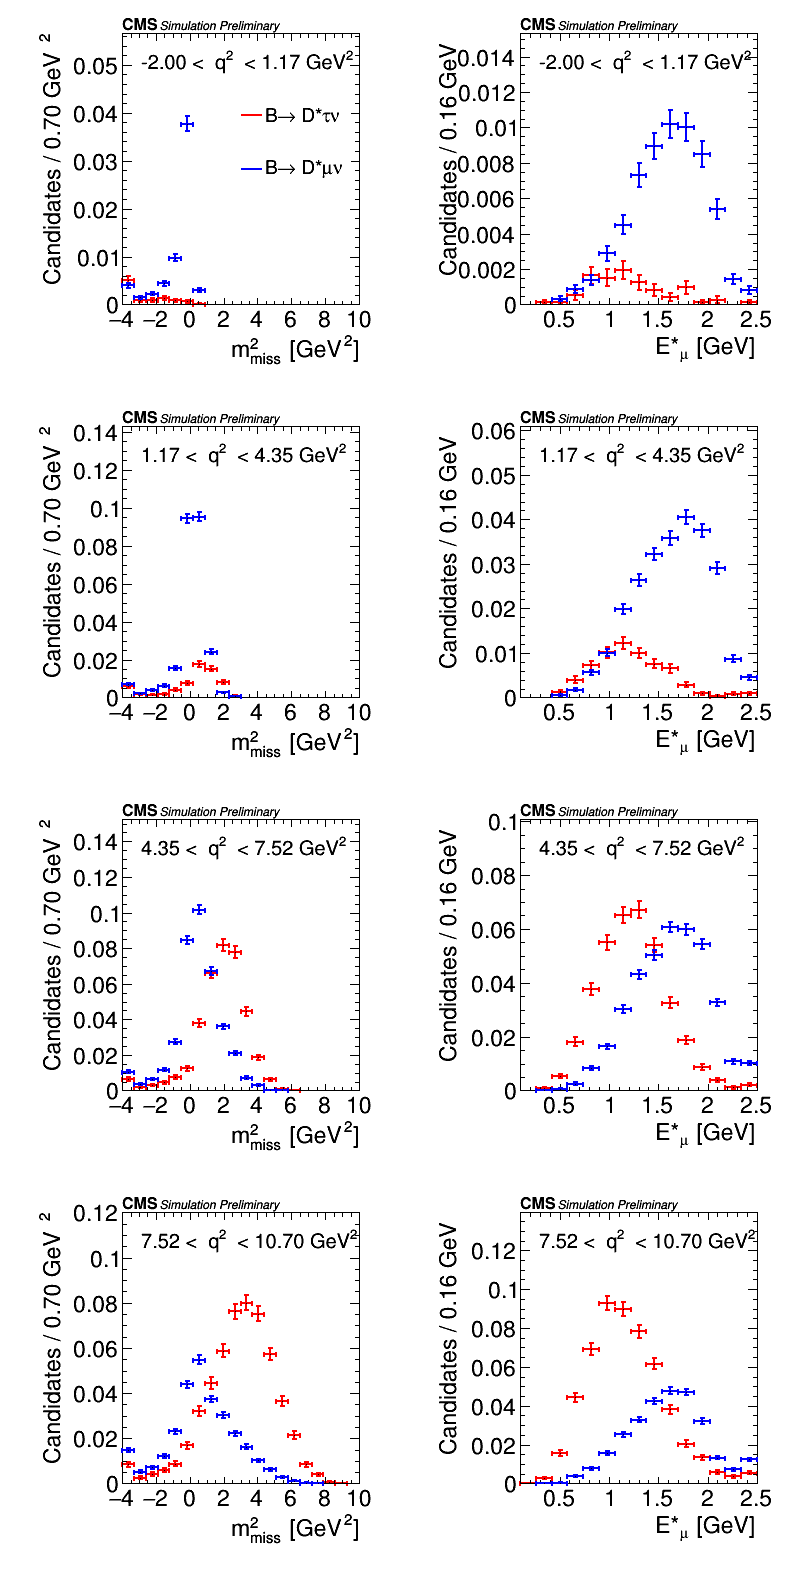

In [22]:
binning = {}
binning['M2_miss'] = [40/2, -4, 10]
binning['Est_mu'] = [30/2, 0.10, 2.500]

canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_var*400, 400*N_q2bins)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_var, N_q2bins)

CMS_lumi.extraText = "        Simulation Preliminary"

vars_to_plot = ['M2_miss', 'Est_mu']

for i_q2 in range(N_q2bins):
    q2_l = binning_q2[i_q2]
    q2_h = binning_q2[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)

    for i_v, vark in enumerate(vars_to_plot):
        h_bname = 'h_{}_{}'.format(i_q2, i_v)

        h_dic = {}
        for k, t in zip(['mu', 'tau'], [dMC, dMC_tau]):
            aux = t[vark][q2_sel(t, q2_l, q2_h)]
            h_dic[k] = create_TH1D(aux, h_bname+'_aux_'+k, binning=binning[vark], opt='overflow+underflow')
#             h_dic[k].Scale(overall_scale_factor)

#         h_dic['tau'].Scale(0.3*0.17) #R(D*)*Br(tau->mu)


        h = rt.TH1D(h_bname+'_tau', h_bname+'_tau', binning[vark][0], binning[vark][1], binning[vark][2])
        h.Add(h_dic['tau'])#, h_dic['mu']) #Just because we want to show them separate
        h.SetLineColor(2)
        h.GetXaxis().SetTitle(xAx_title[vark])
        h.GetXaxis().SetTitleSize(0.07)
        h.GetXaxis().SetLabelSize(0.07)
        h.GetYaxis().SetTitleOffset(1.7)
        h.GetXaxis().SetTitleOffset(1.1)
        h.GetYaxis().SetTitleSize(0.07)
        h.GetYaxis().SetLabelSize(0.07)
        iunits = xAx_title[vark].find('[') + 1
        h.GetYaxis().SetTitle('Candidates / {:.2f} '.format(h.GetBinWidth(1)) + xAx_title[vark][iunits:-1])

        h2 = h_dic['mu'].Clone(h_bname+'_mu')
        h2.SetLineColor(4)

        i_pad = i_q2*N_var + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetBottomMargin(0.2)
        pad.SetRightMargin(0.08)
        pad.SetLeftMargin(0.3)

        # Normalize them to unity....
        h.Scale(1./dMC_tau[vark].shape[0])
        h2.Scale(1./dMC[vark].shape[0])
        h.GetYaxis().SetRangeUser(0, 1.5*np.max([x.GetMaximum() for x in [h, h2]]))


        h.Draw('E1')
        h2.Draw('E1SAME')

        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.06)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.35, 0.85, q2_txt)

        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)

        if 'ip' in vark:
            maxs = [x.GetMaximum() for x in [h, h2]]
            h.GetYaxis().SetRangeUser(1e-4, 1.5*np.max(maxs))
            pad.SetLogy()

        if i_pad == 1:
            leg = rt.TLegend(0.6, 0.5, 0.9, 0.8)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(0)
            leg.SetBorderSize(0)
            leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'l')
            leg.AddEntry(h2, 'B#rightarrow D*#mu#nu', 'l')
            leg.Draw()

        donotdelete.append([h, h2])

canvas.Draw()
canvas.SaveAs('/Users/olmo/Desktop/AnalysisVars_wGlobalNorm.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out
Warning in <TROOT::Append>: Replacing existing TH1: h_0_aux_mu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_0_aux_tau (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_1_aux_mu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_1_aux_tau (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_2_aux_mu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_2_aux_tau (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_3_aux_mu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_3_aux_tau (Potential memory leak).


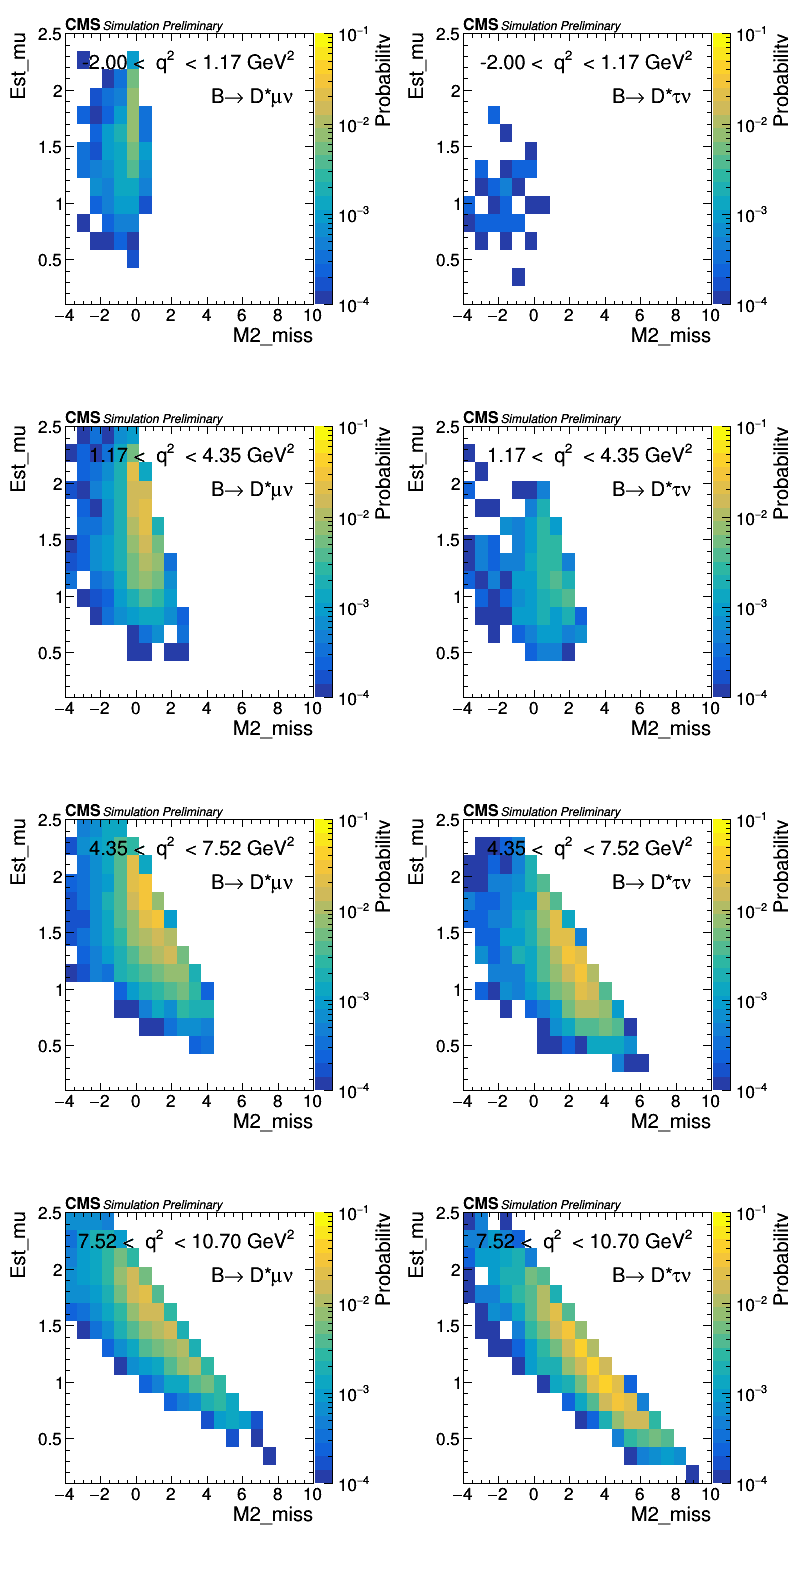

In [40]:
canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_var*400, 400*N_q2bins)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(2, N_q2bins)

CMS_lumi.extraText = "        Simulation Preliminary"

vars_to_plot = ['M2_miss', 'Est_mu']

for i_q2 in range(N_q2bins):
    q2_l = binning_q2[i_q2]
    q2_h = binning_q2[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)
    
    for i_p, (k, t) in enumerate(zip(['mu', 'tau'], [dMC, dMC_tau])):
        x = t[vars_to_plot[0]][q2_sel(t, q2_l, q2_h)]
        y = t[vars_to_plot[1]][q2_sel(t, q2_l, q2_h)]
        h = create_TH2D(np.column_stack((x,y)), 
                               'h_{}'.format(i_q2)+'_aux_'+k, 
                               binning=binning[vars_to_plot[0]]  + binning[vars_to_plot[1]],
                               axis_title=vars_to_plot+['Probability']
                              )
        h.Scale(1./t[vars_to_plot[0]].shape[0])
        
        
        i_pad = i_q2*2 + i_p + 1
        pad = canvas.cd(i_pad)
        pad.SetBottomMargin(0.2)
        pad.SetRightMargin(0.2)
        pad.SetLeftMargin(0.15)

        h.Draw('colz')
        h.GetZaxis().SetRangeUser(1e-4, 1e-1)
        h.GetZaxis().SetTitleOffset(1.4)
        pad.SetLogz()
        
        l = rt.TLatex()
        l.SetTextAlign(31)
        l.SetTextSize(0.06)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.75, 0.85, q2_txt)
        
        p_string = 'B#rightarrow D*#tau#nu'
        if k == 'mu':
            p_string = 'B#rightarrow D*#mu#nu'
        l.SetTextAlign(33)
        l.SetTextSize(0.06)
        l.DrawLatexNDC(0.75, 0.8, p_string)
        
        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)
        
        donotdelete.append(h)
canvas.Draw()
# canvas.SaveAs('/Users/olmo/Desktop/AnalysisVars_wGlobalNorm.png')

## RD only

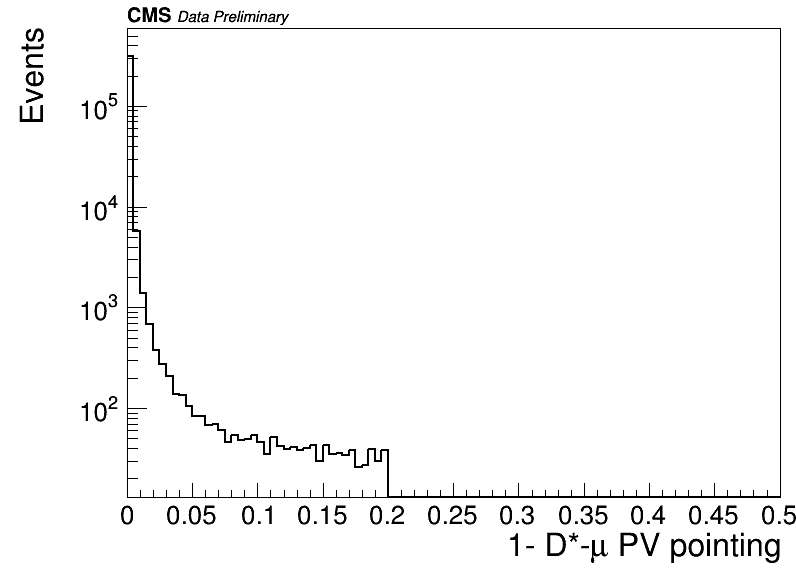

In [24]:
h = create_TH1D(1-dRD['cos_MuDst_vtxBest'], axis_title=['1- D*-#mu PV pointing', 'Events'], binning=[100,0.,0.5])
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h])
c.SetLogy()

<ROOT.TLine object ("TLine") at 0x7fc68308e0d0>

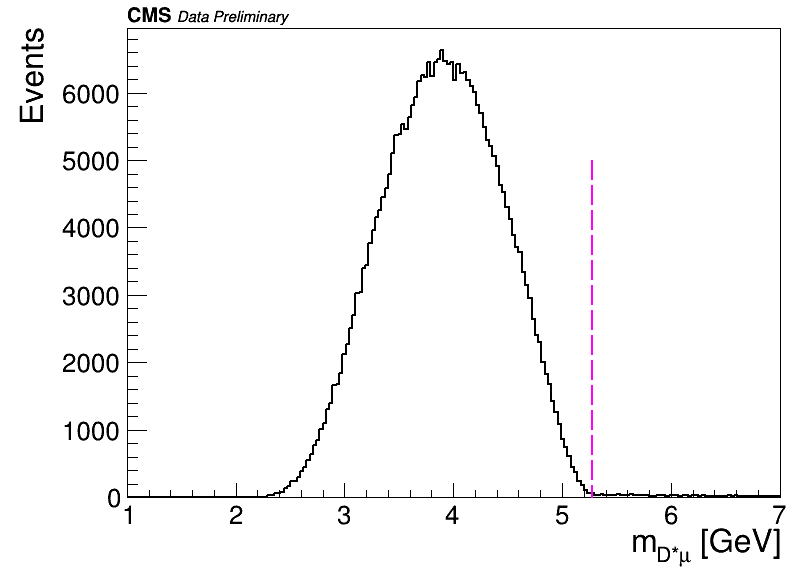

In [25]:
h = create_TH1D(dRD['mass_MuDst'], axis_title=['m_{D*#mu} [GeV]', 'Events'], binning=[200,1,7])
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h])
cl.DrawLine(m_B0, 0, m_B0, 5000)

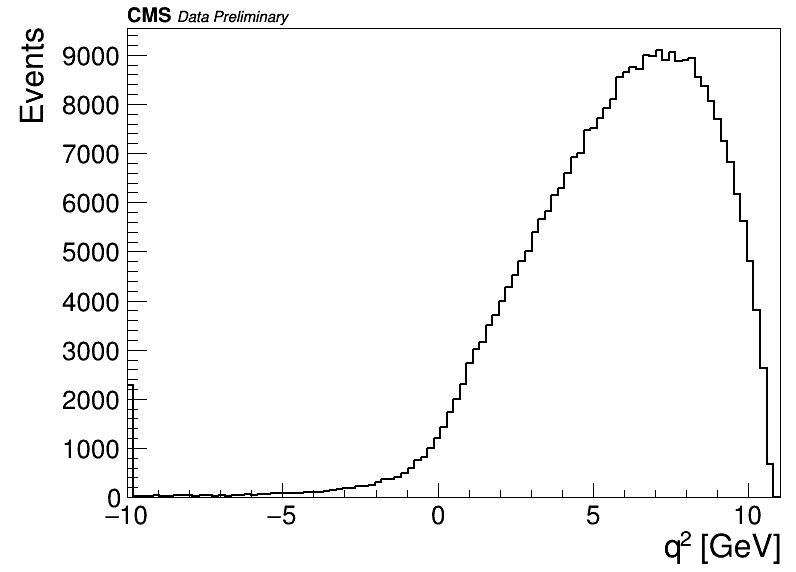

In [26]:
h = create_TH1D(dRD['q2'], axis_title=['q^{2} [GeV]', 'Events'], binning=[100,-10,11], opt='underflow')
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h])

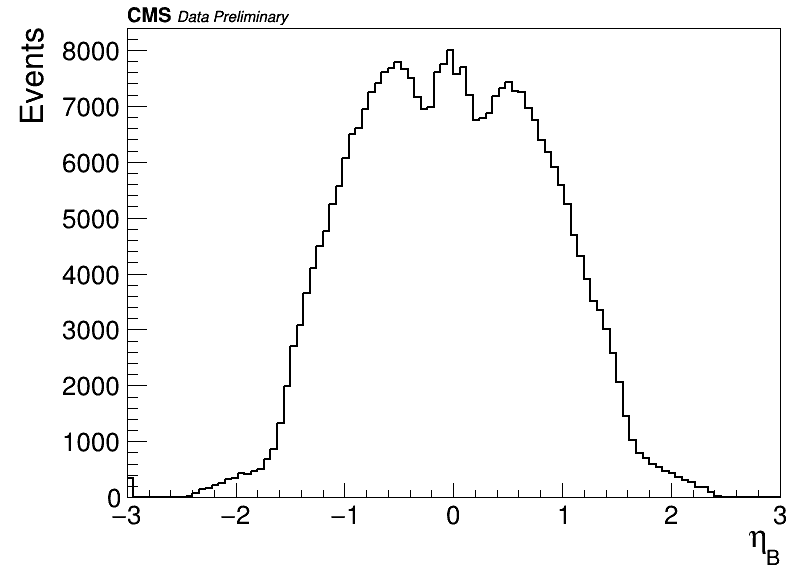

In [27]:
h = create_TH1D(dRD['B_eta'], axis_title=['#eta_{B}', 'Events'], binning=[100,-3,3], opt='underflow')
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [h])

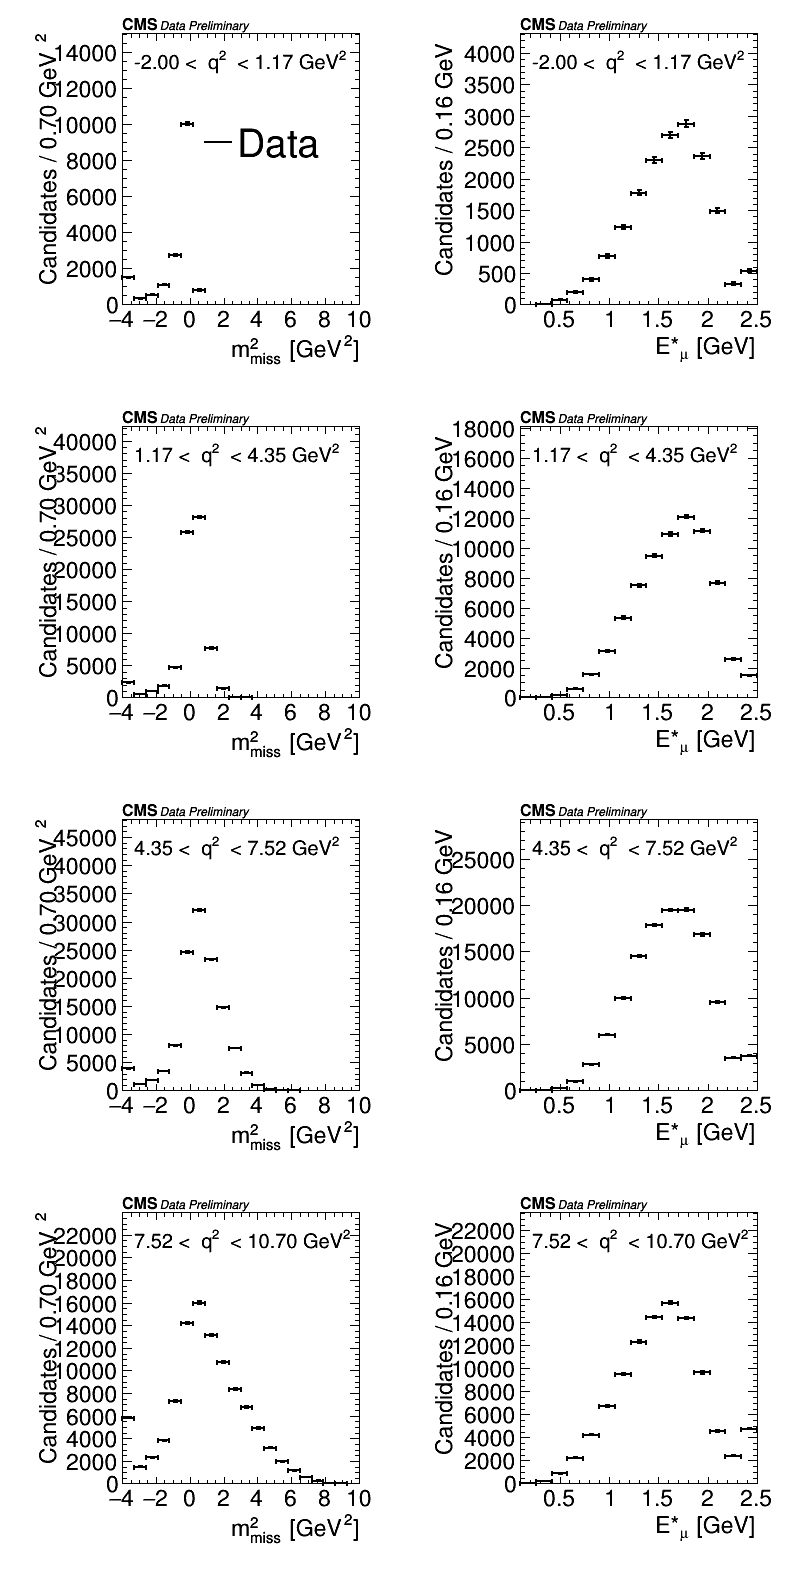

In [28]:
binning = {}
binning['M2_miss'] = [40/2, -4, 10]
binning['Est_mu'] = [30/2, 0.10, 2.500]

canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_var*400, 400*N_q2bins)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_var, N_q2bins)

CMS_lumi.extraText = "        Data Preliminary"

vars_to_plot = ['M2_miss', 'Est_mu']

for i_q2 in range(N_q2bins):
    q2_l = binning_q2[i_q2]
    q2_h = binning_q2[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)

    for i_v, vark in enumerate(vars_to_plot):
        h_bname = 'h_{}_{}'.format(i_q2, i_v)

        h_dic = {}
        for k, t in zip(['data'], [dRD]):
            aux = t[vark][q2_sel(t, q2_l, q2_h)]
            h_dic[k] = create_TH1D(aux, h_bname+'_aux_'+k, binning=binning[vark], opt='underflow+overflow')
#             h_dic[k].Scale(overall_scale_factor)

#         h_dic['tau'].Scale(0.3*0.17) #R(D*)*Br(tau->mu)


        h = rt.TH1D(h_bname+'_data', h_bname+'_data', binning[vark][0], binning[vark][1], binning[vark][2])
        h.Add(h_dic['data'])#, h_dic['mu']) #Just because we want to show them separate
        h.SetLineColor(1)
        h.GetXaxis().SetTitle(xAx_title[vark])
        h.GetXaxis().SetTitleSize(0.07)
        h.GetXaxis().SetLabelSize(0.07)
        h.GetYaxis().SetTitleOffset(1.8)
        h.GetXaxis().SetTitleOffset(1.1)
        h.GetYaxis().SetTitleSize(0.07)
        h.GetYaxis().SetLabelSize(0.07)
        iunits = xAx_title[vark].find('[') + 1
        h.GetYaxis().SetTitle('Candidates / {:.2f} '.format(h.GetBinWidth(1)) + xAx_title[vark][iunits:-1])

        i_pad = i_q2*N_var + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetBottomMargin(0.2)
        pad.SetRightMargin(0.08)
        pad.SetLeftMargin(0.3)

        # Normalize them to unity....
#         h.Scale(1./h.Integral())
#         h2.Scale(1./h2.Integral())
        h.GetYaxis().SetRangeUser(0, 1.5*np.max([x.GetMaximum() for x in [h, h2]]))


        h.Draw('E1')

        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.06)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.33, 0.85, q2_txt)

        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)

        if 'ip' in vark:
            maxs = [x.GetMaximum() for x in [h, h2]]
            h.GetYaxis().SetRangeUser(1e-4, 1.5*np.max(maxs))
            pad.SetLogy()

        if i_pad == 1:
            leg = rt.TLegend(0.5, 0.5, 0.9, 0.8)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(0)
            leg.SetBorderSize(0)
            leg.AddEntry(h, 'Data', 'l')
            leg.Draw()

        donotdelete.append([h, h2])

canvas.Draw()
canvas.SaveAs('/Users/olmo/Desktop/AnalysisVars_wGlobalNorm_data.png')